In [46]:
import pandas as pd 
import torch
import json 
import os 

from torch.utils.data import DataLoader

from gptonly import GPT
from gptonly.utils import plot_trp
from gptonly.train import get_latest_model, get_abs_path

from data import GenerationDM

import matplotlib.pyplot as plt 

In [48]:
def plot_trp(
        trp,
        text=None,
        eos_token="[SEP]",
        figsize=(9,3),
        plot=False,
        max_idx_plot=-1
    ):
    fig, ax = plt.subplots(1,1, figsize=figsize)

    x = torch.arange(len(trp))
    ax.bar(x, trp, width=.3, color='b', label='TRP')
    ax.set_xticks(x)

    ax.set_xticklabels(text, rotation=60)
    for idx, text in enumerate(text):
        if text == eos_token:
            ax.vlines(idx, ymin=0, ymax=1, linestyle="dashed", color="r")
        if idx == max_idx_plot:
            ax.vlines(idx, ymin=0, ymax=1, linestyle="solid", color="g")

    ax.set_ylim([0,1])
    ax.legend()
    fig.tight_layout()

    if plot:
        plt.pause(0.01)
    return fig, ax

In [2]:
device = "cuda:0"
LOAD_PATH = "trained_model/2024-01-09:08-52-42"

In [3]:
model = GPT(
        pretrained_model_name="gpt2",
        finetune=True,
        device=device,
        speaker_tokens=True,
        projection_labels=False,
    )

model.to(device)

Tokenizer initialization:
	We added 4 tokens -> Special token map
	bos_token: <|endoftext|>
	eos_token: <ts>
	unk_token: <|endoftext|>
	pad_token: <|endoftext|>
	additional_special_tokens: ['<speaker1>', '<speaker2>']

Initalized <ts> -> avg(['!', '?', '.'])


GPT(
  (dropout): Dropout(p=0.1, inplace=False)
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50260, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50260, bias=False)
  )
  (

In [4]:
criterion = torch.nn.CrossEntropyLoss().to(device)
# , weight_decay=config.weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [5]:
test_ds = GenerationDM(
            split="test",
            tokenizer=model.get_tokenizer(),
            overwrite=False,
            max_length=200,
            keep_length=64,
            overlap_length=10,
            datasets=["switchboard"],
        )
test_ds.prepare_data()
test_dl = DataLoader(
    test_ds,
    batch_size=4,
    collate_fn=test_ds.collate_fn,
    num_workers=8,
    shuffle=True
)

In [6]:
def load_from_checkpoint(load_model_file):
        try:
            checkpoint = torch.load(load_model_file)
        except:
            load_model_file = get_latest_model(os.path.dirname(
                load_model_file), before=load_model_file)
            load_from_checkpoint()
        else:
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            # self.model.tokenizer.from_pretrained(os.path.join(os.path.dirname(self.load_model_file), "tokenizer"))
            # self.model.init_tokenizer()
            

In [7]:
load_from_checkpoint(get_latest_model(get_abs_path(LOAD_PATH)))

In [8]:
def generate_labels(input_ids, mask=None, pad_id=-100):
        labels = input_ids.clone()
        labels[torch.logical_not(mask)] = pad_id

        return labels

def generate_projection_labels(labels):
    batch_size, num_labels = labels.size()

    mask = (labels == model.tokenizer.eos_token_id)
    distances = torch.full((batch_size, num_labels),
                           num_labels, device=labels.device)
    distances[mask] = 0

    for i in range(num_labels - 2, -1, -1):
        distances[:, i] = torch.minimum(
            distances[:, i], distances[:, i+1] + 1)

    return distances

In [9]:
def is_not_trp_example(logits, labels):
        probs = logits.softmax(dim=-1)
        trp_prob = probs[..., model.tokenizer.eos_token_id]
        trp_prob = trp_prob[..., :-1]

        labels = labels[..., 1:]
        is_trp = labels == model.tokenizer.eos_token_id
        not_trp = labels != model.tokenizer.eos_token_id

        return torch.max(trp_prob - is_trp.long()).item() > 0.5

In [83]:
batches = []
BATCHES_LENGTH = 20
model.eval()

keys = dict(count_list[:10])
print(keys) 

outputs = {}
with torch.no_grad():
    for step, batch in enumerate(test_dl):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        labels = generate_labels(input_ids, mask=attention_mask)
        projection_labels = generate_projection_labels(labels)
        out = model.forward(
            input_ids, labels=labels, projection_labels=projection_labels, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        logits = out.logits 

        probs = logits.softmax(dim=-1)
        trp_prob = probs[..., model.tokenizer.eos_token_id]
        #trp_prob = trp_prob[..., :-1]
        
        #labels = labels[..., 1:]
        is_trp = labels == model.tokenizer.eos_token_id
        not_trp = labels != model.tokenizer.eos_token_id

        for j in range(len(trp_prob)):
            lt = labels[j][1:]
            it = lt == model.tokenizer.eos_token_id
            tr = trp_prob[j][:-1]
            # max_val is large when not trp but large trp prediction
            max_val = torch.max(tr - it.long())
            max_idx = torch.argmax(tr - it.long())

            if lt[max_idx-1].item() in keys:
                continue 
            
            if len(batches) >= BATCHES_LENGTH and batches[0][2] <= max_val:
                batches.pop(0)
            elif len(batches) >= BATCHES_LENGTH:
                continue
                
            i = 0 
            while i < len(batches) and batches[i][2] < max_val:
                i+=1

            batches.insert(i, (trp_prob[j], labels[j], max_val, max_idx))

{7456: 1792, 17047: 1702, 10194: 762, 826: 759, 340: 281, 345: 261, 24926: 250, 1107: 221, 8788: 179, 326: 153}


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

In [84]:
for j in range(len(batches)):
    max_idx = batches[j][3]
    max_val = batches[j][2]
    trp_prob = batches[j][0]
    labels = batches[j][1]

    """
    print(trp_prob[max_idx-5:max_idx+5])
    print(labels[max_idx-5:max_idx+5])
    is_trp = labels == model.tokenizer.eos_token_id
    
    print((trp_prob - is_trp.long())[max_idx-5:max_idx+5])
    print((trp_prob[:-1] - is_trp[1:].long())[max_idx-5:max_idx+5])
    print(max_val, max_idx)
    print("------------------------")
    """
    

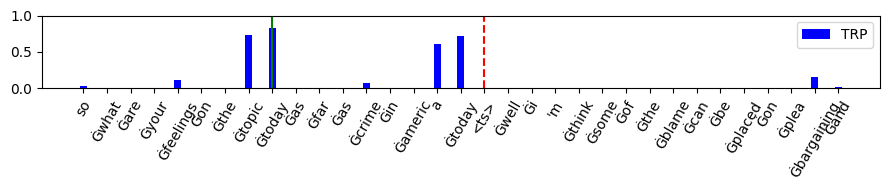

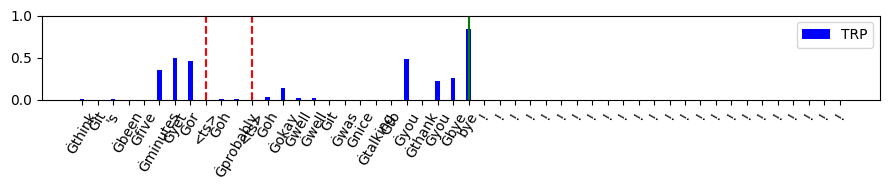

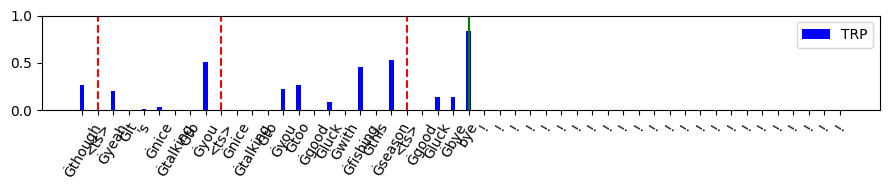

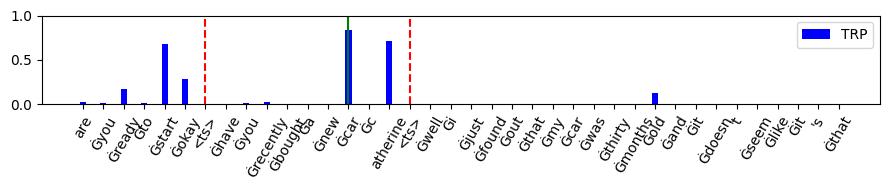

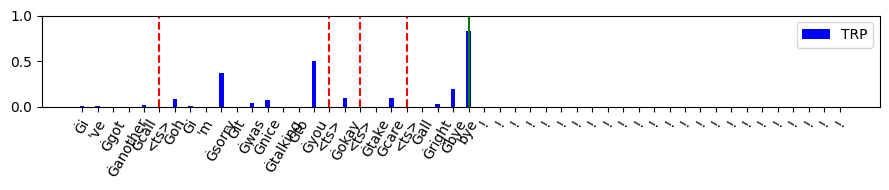

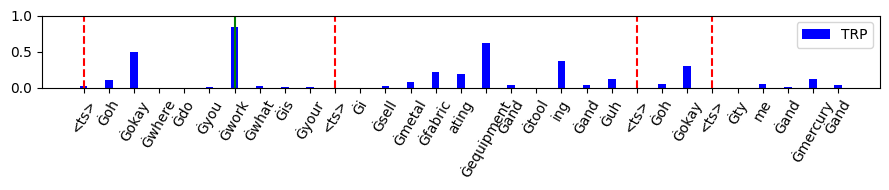

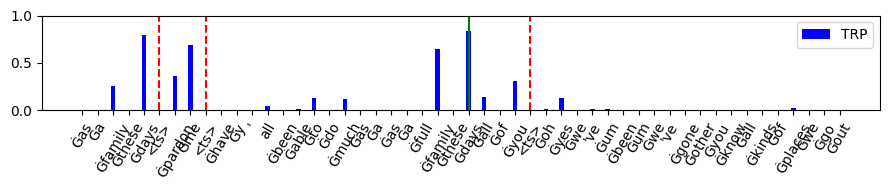

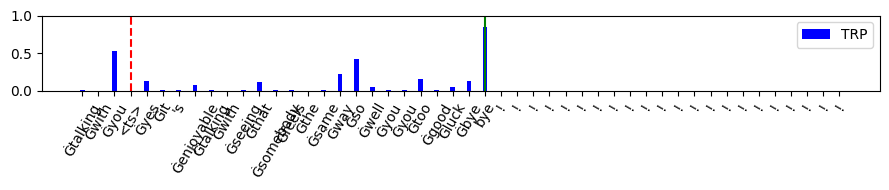

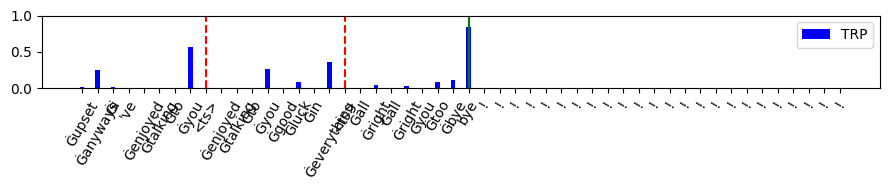

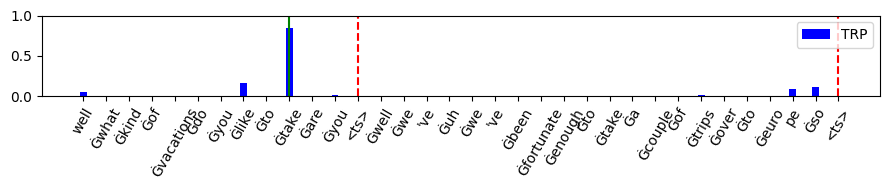

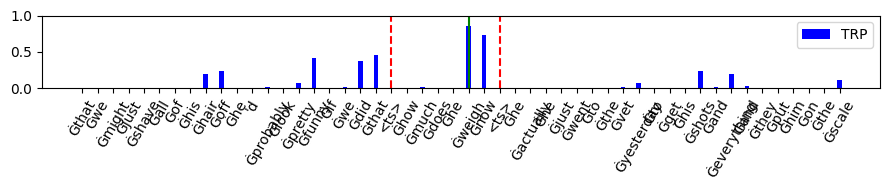

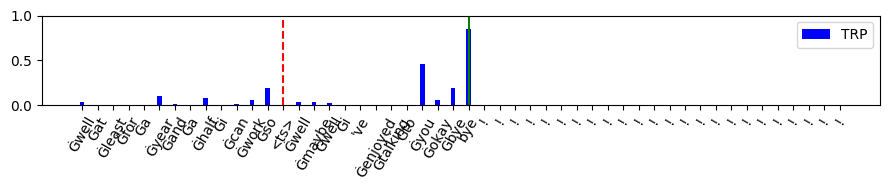

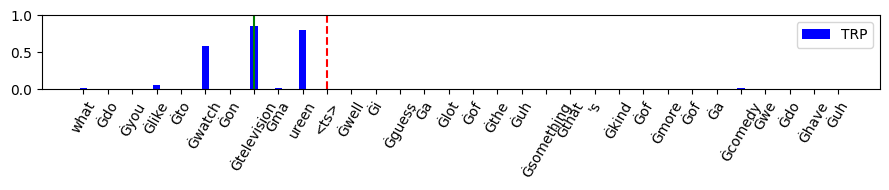

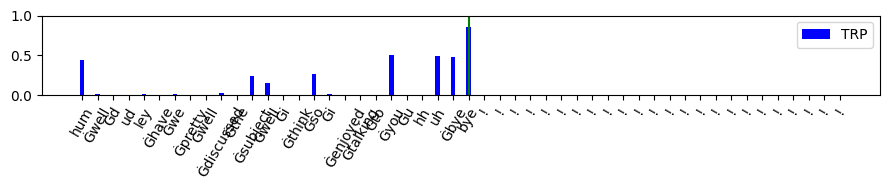

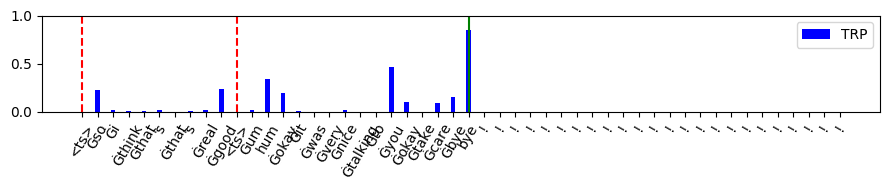

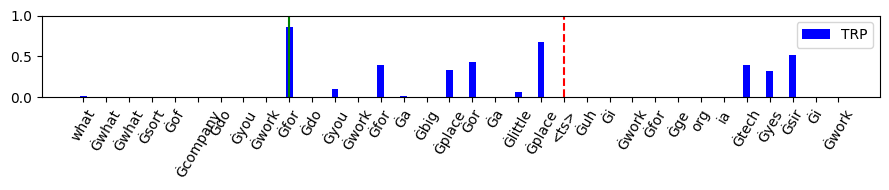

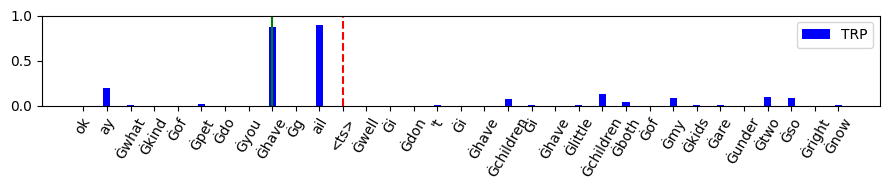

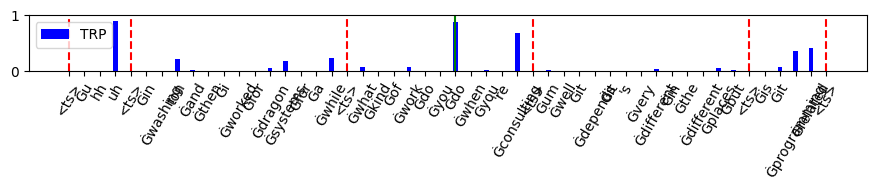

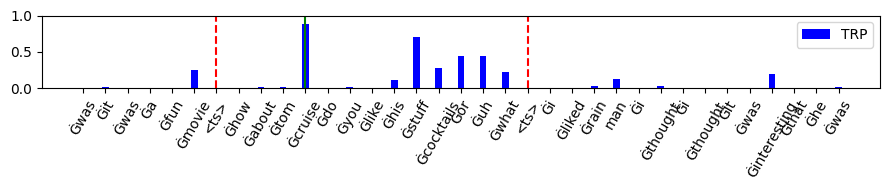

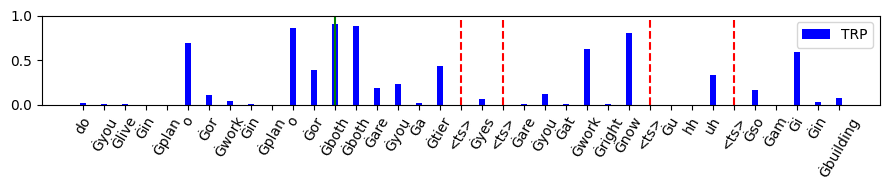

In [91]:
figs = []
for b in range(len(batches)):
    idx = batches[b][3].item()
    lower, upper = max(idx-25,0), min(idx+25, len(batches[b][0]))
    batches[b][1][batches[b][1] == -100] = 0
    text = model.tokenizer.convert_ids_to_tokens(batches[b][1][lower:upper])
    fig, _ = plot_trp(
        trp=batches[b][0][lower:upper].cpu(),
        text=text,
        eos_token='<ts>',
        max_idx_plot = idx - lower,
        figsize=(9,2)
    )
    figs.append(fig)

In [13]:
# most common words prior <ts> GROUND TRUTH
counter = {} 
for step, batch in enumerate(test_dl):
    input_ids = batch['input_ids'].to(device).flatten() 
    
    positions = (input_ids == model.tokenizer.eos_token_id).nonzero(as_tuple=True)[0]

    for pos in positions:
        if pos <= 0:
            continue 
            
        word = input_ids[pos-1].item()
        if word not in counter:
            counter[word] = 0
        counter[word] += 1

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

In [14]:
count_list = [(k,v) for k, v in counter.items()]
count_list.sort(key=lambda k: k[1], reverse=True)

In [15]:
data = count_list[:10]
model.tokenizer.convert_ids_to_tokens([x[0] for x in data])

['Ġyeah', 'uh', 'hum', 'Ġright', 'Ġit', 'Ġthat', 'Ġknow', 'Ġuh', 'Ġso', 'Ġand']

<BarContainer object of 10 artists>

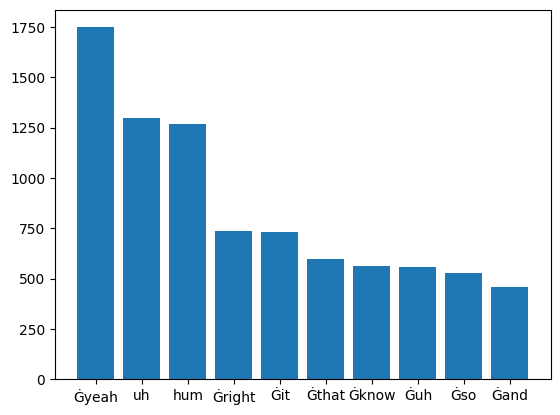

In [16]:
plt.bar(
    model.tokenizer.convert_ids_to_tokens([x[0] for x in data]),
    [x[1] for x in data]
)

In [38]:
# most common words prior <ts> PREDICTED
counter = {} 
for step, batch in enumerate(test_dl):
    input_ids = batch['input_ids'].to(device) 
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)

    labels = generate_labels(input_ids, mask=attention_mask)
    projection_labels = generate_projection_labels(labels)
    out = model.forward(
        input_ids, labels=labels, projection_labels=projection_labels, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
    logits = out.logits

    probs = logits.softmax(dim=-1)
    trp_prob = probs[..., model.tokenizer.eos_token_id]
    trp_prob = trp_prob[..., :-1]
    
    labels = labels[..., 1:]
    is_trp = labels == model.tokenizer.eos_token_id
    not_trp = labels != model.tokenizer.eos_token_id

    labels = labels.flatten()
    trp_prob = trp_prob.flatten()
    positions = (trp_prob > 0.4).nonzero(as_tuple=True)[0]

    for pos in positions:
        word = labels[pos-1].item()
        if word not in counter:
            counter[word] = 0
        counter[word] += 1

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

In [39]:
count_list = [(k,v) for k, v in counter.items()]
count_list.sort(key=lambda k: k[1], reverse=True)

<BarContainer object of 10 artists>

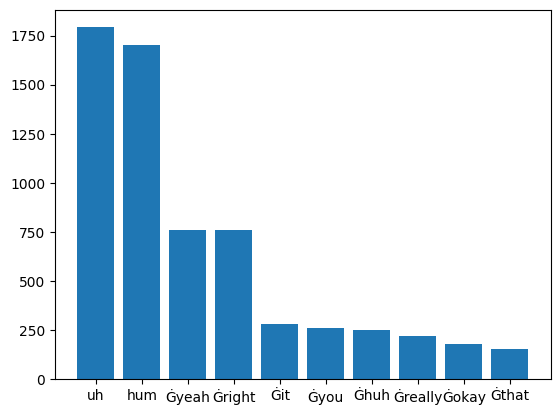

In [40]:
data = count_list[:10]
plt.bar(
    model.tokenizer.convert_ids_to_tokens([x[0] for x in data]),
    [x[1] for x in data]
)

In [93]:
iterator=iter(test_dl)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `_

In [112]:
batch = next(iterator)
batch['input_ids']

tensor([[  257,  2130,   345,   886,   510,   351,  2130,   508,   338,   517,
          4923,   284,  3592,   780,   484,  1682,   714, 25451,   777,  6066,
           329,   257,   890,   640, 50257, 10194,   484,   714,  2192,  2192,
           466,   340,   757, 50257,  3763,   484,   484,   561,   423,   645,
          2761,  1804,   340,   757, 50257,   326,   338,   826,   484,  1422,
           470,   423,   597,   640,  1804,   340,   262,   717,   640, 50257,
         23781, 17047,   290,  1312,   892, 22656,   606,   510,   329,   345,
           760, 15334,   812,  1595,   470,   466, 21480,   597,   922,   780,
           355,   257,   355,   257, 14776,  1312,  1101,  1016,   284,  1414,
           345,   760,   530,   290,   257, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 5

In [122]:
id = batch['input_ids']
model.tokenizer.pad_token_id

50256

In [130]:
torch.column_stack((id, torch.tensor([0,0,0,0])))

tensor([[  257,  2130,   345,   886,   510,   351,  2130,   508,   338,   517,
          4923,   284,  3592,   780,   484,  1682,   714, 25451,   777,  6066,
           329,   257,   890,   640, 50257, 10194,   484,   714,  2192,  2192,
           466,   340,   757, 50257,  3763,   484,   484,   561,   423,   645,
          2761,  1804,   340,   757, 50257,   326,   338,   826,   484,  1422,
           470,   423,   597,   640,  1804,   340,   262,   717,   640, 50257,
         23781, 17047,   290,  1312,   892, 22656,   606,   510,   329,   345,
           760, 15334,   812,  1595,   470,   466, 21480,   597,   922,   780,
           355,   257,   355,   257, 14776,  1312,  1101,  1016,   284,  1414,
           345,   760,   530,   290,   257, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 5